# UE21CS343AA2 - DATA ANALYTICS HACKATHON 
# FACULTY : DR SUDEEPA ROY DEY
# TEAM NAME : BUN SAMOSA
# TEAM MEMBERS: 
#      MURARI B DESHPANDE (PES2UG21CS309)
#      N.P.PRAGASHRI (PES2UG21CS311)
#      NETRA D PATEL (PES2UG21CS330)
# SECTION : F

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ue21cs342aa2/sample_submission.csv
/kaggle/input/ue21cs342aa2/train.csv
/kaggle/input/ue21cs342aa2/test.csv


In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import warnings
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
from sklearn.impute import SimpleImputer
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

**The code imports necessary libraries for data analysis, preprocessing, time series analysis, and machine learning, suggesting a comprehensive data analysis and modeling pipeline. However, specific details of the analysis cannot be determined without examining the actual code and data.**

In [3]:
warnings.simplefilter("ignore")

In [4]:
def compute_rsi(data, window=14):
    delta = data.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_macd(data, short_window=10, long_window=24):
    short_ema = data.ewm(span=short_window, adjust=False).mean()
    long_ema = data.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    return macd

def compute_obv(data, volume):
    obv = [0]
    for i in range(1, len(data)):
        if data[i] > data[i - 1]:
            obv.append(obv[-1] + volume[i])
        elif data[i] < data[i - 1]:
            obv.append(obv[-1] - volume[i])
        else:
            obv.append(obv[-1])
    return pd.Series(obv, index=data.index)

**The provided code defines functions to calculate our features from feature engineering for 'Close' price forecasting:**

1. `compute_rsi(data, window=14)` calculates the Relative Strength Index (RSI) for price data.
2. `compute_macd(data, short_window=10, long_window=24)` calculates the Moving Average Convergence Divergence (MACD) for price data.
3. `compute_obv(data, volume)` computes the On-Balance Volume (OBV) using price and trading volume data.

**These functions are useful for analyzing stock market trends and trading volumes.**

In [5]:
def calculate_volatility_bbm(data, window=20):
    return data['Close'].rolling(window=window).mean()

def calculate_volatility_bbw(data, window=20):
    sma = calculate_volatility_bbm(data, window)
    return data['Close'].rolling(window=window).std() / sma

def calculate_volatility_bbp(data, window=20):
    sma = calculate_volatility_bbm(data, window)
    return (data['Close'] - sma) / (2 * data['Close'].rolling(window=window).std())

def calculate_momentum_rsi(data, window=14):
    return 100 - (100 / (1 + calculate_rsi(data, window)))

def calculate_trend_macd(data, short_window=16, long_window=30):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    return short_ema - long_ema

def calculate_volume_obv(data):
    return (data['Volume'] * ((data['Close'] - data['Open']) >= 0).astype(int).apply(lambda x: 2*x-1)).cumsum()

def calculate_rsi(data, window=14):
    price_diff = data['Close'].diff(1)
    gain = price_diff.where(price_diff > 0, 0)
    loss = -price_diff.where(price_diff < 0, 0)

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    relative_strength = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + relative_strength))

    return rsi

**The code defines functions to compute common financial indicators like Bollinger Bands (BBM, BBW, BBP), Relative Strength Index (RSI), Moving Average Convergence Divergence (MACD), and On-Balance Volume (OBV). These indicators are fundamental for technical analysis and feature engineering in financial data for evaluating market trends, volatility, momentum, and trading signals.**

1. `volatility_bbm`: Rolling mean of the 'Close' price with a window of 20 periods.
2. `volatility_bbw`: Rolling standard deviation of 'Close' divided by 'volatility_bbm'.
3. `volatility_bbp`: Relative position of 'Close' price with respect to 'volatility_bbm' and 'volatility_bbw'.
4. `momentum_rsi`: Relative Strength Index (RSI) of the 'Close' price with a 14-period window.
5. `trend_macd`: Moving Average Convergence Divergence (MACD) of the 'Close' price with short and long windows of 16 and 30 periods.
6. `volume_obv`: On-Balance Volume (OBV) calculated based on 'Volume', 'Open', and 'Close' prices.
7. `rsi`: RSI calculated based on the price differences in 'Close' with a 14-period window.

In [6]:
ts_data = pd.read_csv("/kaggle/input/ue21cs342aa2/train.csv")
ts_data['Date'] = pd.to_datetime(ts_data['Date'])
ts_data.set_index('Date', inplace=True)
ts_data.head()

,id,Open,Close,Volume,Strategy
Date,,,,,
2015-06-01,0,66.208486,75.609978,298506300,Hold
2015-06-08,1,64.116235,74.443331,227974800,Hold
2015-06-15,2,47.701942,71.140831,250670900,Buy
2015-06-22,3,54.754816,72.881344,223614300,Hold
2015-06-29,4,48.031899,66.284718,406814900,Buy


**The code loads time series data from a CSV file, converts the 'Date' column to a datetime format, and sets the 'Date' column as the index of the DataFrame. This preparation is essential for working with time series data, ensuring that it is indexed correctly for further analysis.**

# EDA - EXPLANATORY DATA ANALYSIS

In [7]:
ts_data.isnull().sum()

id          0
Open        0
Close       0
Volume      0
Strategy    0
dtype: int64

**The code checks for missing values and duplicates in the time series data. It reports the number of missing values and duplicates, which are essential for data quality assessment and data preprocessing before analysis. There are no NULL values in the dataset, it is pretty clean!**

In [8]:
ts_data.duplicated().sum()

0

**This part checks for the number of duplicates in the dataset, but there seems to be NONE! :)**

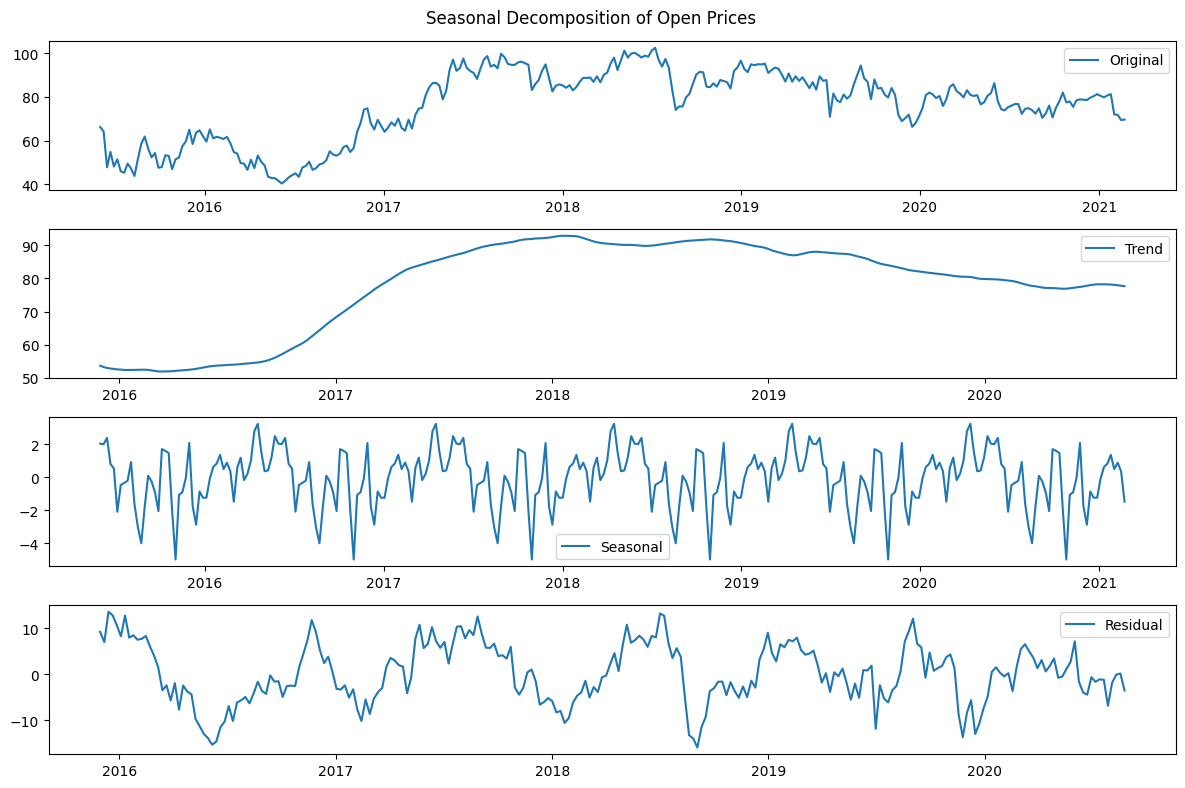

In [9]:
result_open = seasonal_decompose(ts_data['Open'], model='additive')

result_close = seasonal_decompose(ts_data['Close'], model='additive')

plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(ts_data['Open'], label='Original')
plt.legend(loc='best')
plt.subplot(4, 1, 2)
plt.plot(result_open.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(4, 1, 3)
plt.plot(result_open.seasonal, label='Seasonal')
plt.legend(loc='best')
plt.subplot(4, 1, 4)
plt.plot(result_open.resid, label='Residual')
plt.legend(loc='best')
plt.suptitle("Seasonal Decomposition of Open Prices")

plt.tight_layout()
plt.show()

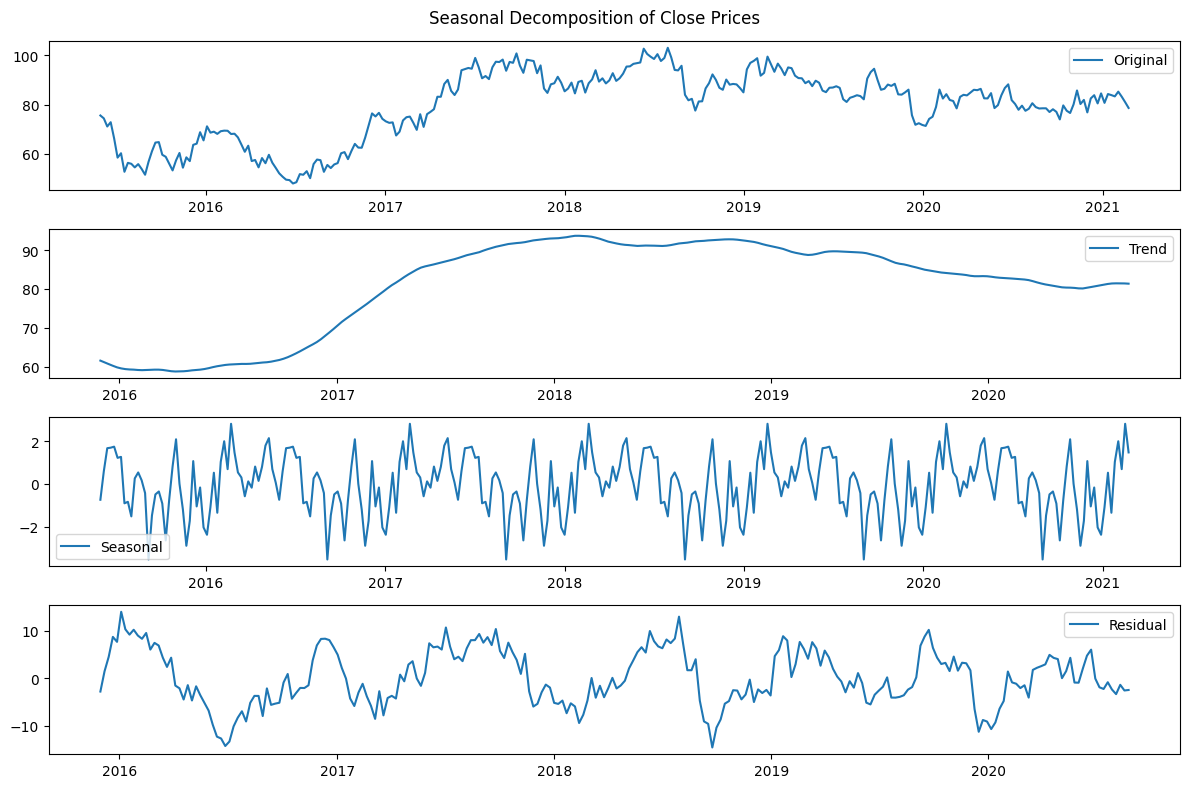

In [10]:
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(ts_data['Close'], label='Original')
plt.legend(loc='best')
plt.subplot(4, 1, 2)
plt.plot(result_close.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(4, 1, 3)
plt.plot(result_close.seasonal, label='Seasonal')
plt.legend(loc='best')
plt.subplot(4, 1, 4)
plt.plot(result_close.resid, label='Residual')
plt.legend(loc='best')
plt.suptitle("Seasonal Decomposition of Close Prices")

plt.tight_layout()
plt.show()

**The code loads training data from a CSV file and performs seasonal decomposition on both "Open" and "Close" prices. It decomposes each time series into its trend, seasonal, and residual components. The code then visualizes the original time series, trend, seasonal, and residual components for both "Open" and "Close" prices using subplots.**

**This analysis helps in understanding the underlying patterns and seasonal variations in the "Open" and "Close" prices of the financial data. It can be valuable for time series forecasting and trend analysis.**

**It shows that both 'Open' and "close" prices dont have a seasoanlity, but definitely do have an upward trend.**

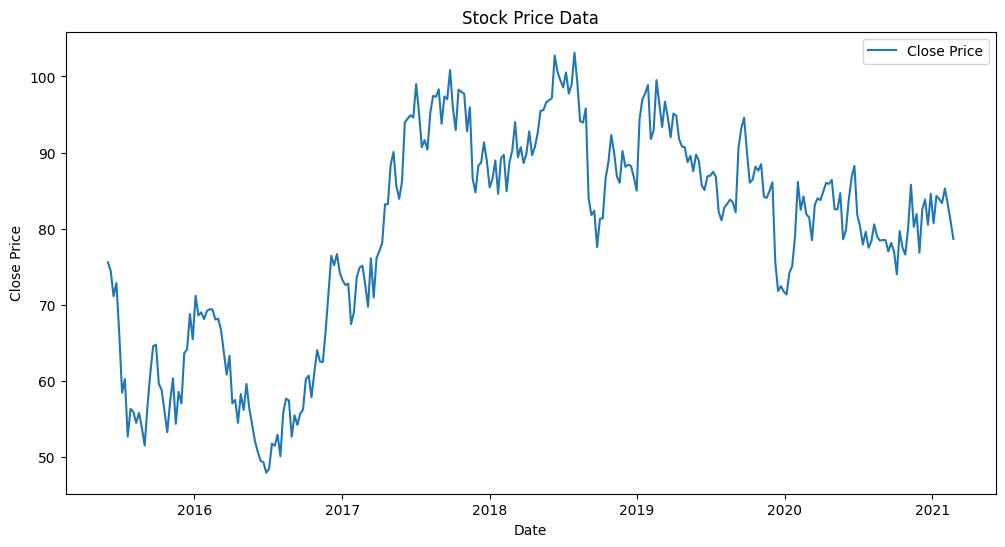

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(ts_data['Close'], label='Close Price')
plt.title('Stock Price Data')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

**The code generates a line plot of the "Close" price data over time. It provides a visual representation of the stock's closing prices.
Inferences:**

**1. The "Close" prices exhibit fluctuating patterns over time, suggesting the presence of trends and fluctuations.**

**2. The visualization serves as an initial step for understanding the stock price trends and patterns in the dataset.**

**PROBABLY OUTBREAK OF COVID-19 AFFECTED THE STOCK PRICES :/**

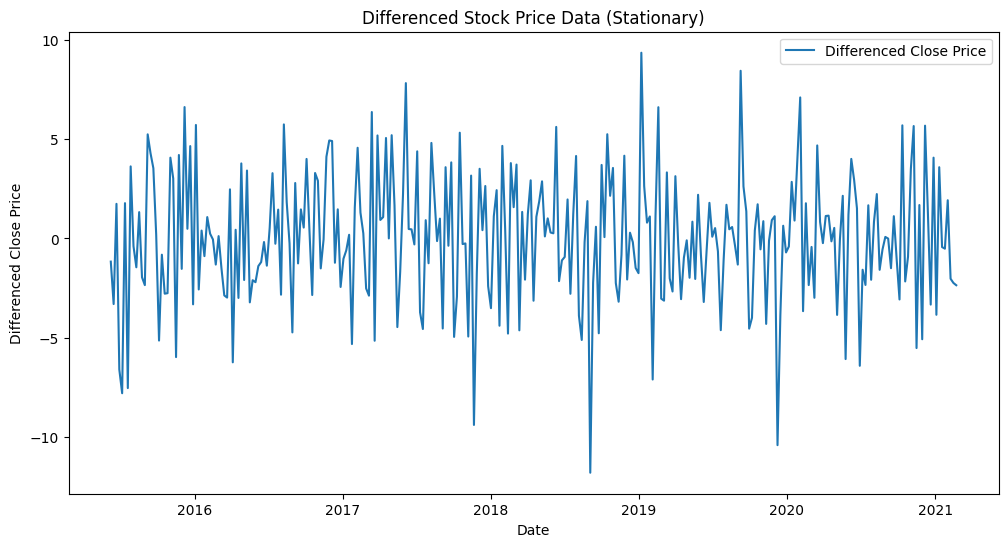

In [12]:
ts_data['CloseDiff'] = ts_data['Close'].diff()
ts_data = ts_data.dropna() 

plt.figure(figsize=(12, 6))
plt.plot(ts_data['CloseDiff'], label='Differenced Close Price')
plt.title('Differenced Stock Price Data (Stationary)')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()
plt.show()

**The code stationarizes the time series data by differencing the 'Close' column, which can help make it suitable for time series analysis. The resulting differenced data is visualized to check for stationarity, which is a crucial step in time series analysis to ensure that statistical properties remain constant over time.
It shows that the data becomes stationary after differencing it once and it is ready for the further steps, here we got our d value to be 1 for the SARIMAX(ARIMAX) model we have tried building.**

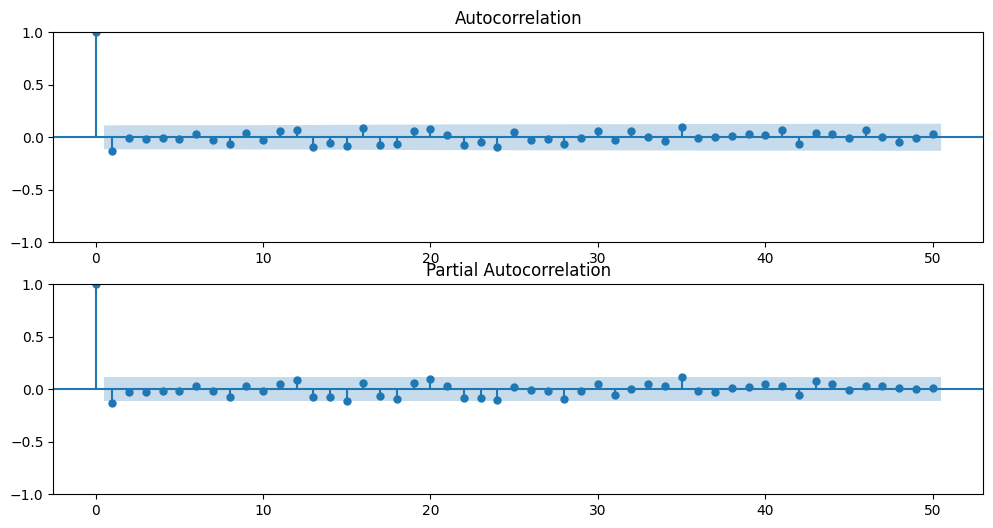

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(ts_data['CloseDiff'], lags=50, ax=ax[0])
plot_pacf(ts_data['CloseDiff'], lags=50, ax=ax[1])
plt.show()

**The code generates ACF and PACF plots for differenced "Close" prices to help identify orders for an ARIMA model.
Inferences:**

**1. ACF plot shows significant autocorrelation at lag 1, suggesting potential AR terms.**

**2. PACF plot exhibits a significant spike at lag 1, indicating a candidate for AR term.**

**3. Possible ARIMAX orders could be ARIMAX(1,1,1) based on these plots.**

**These plots aid in selecting ARIMA model orders effectively.**

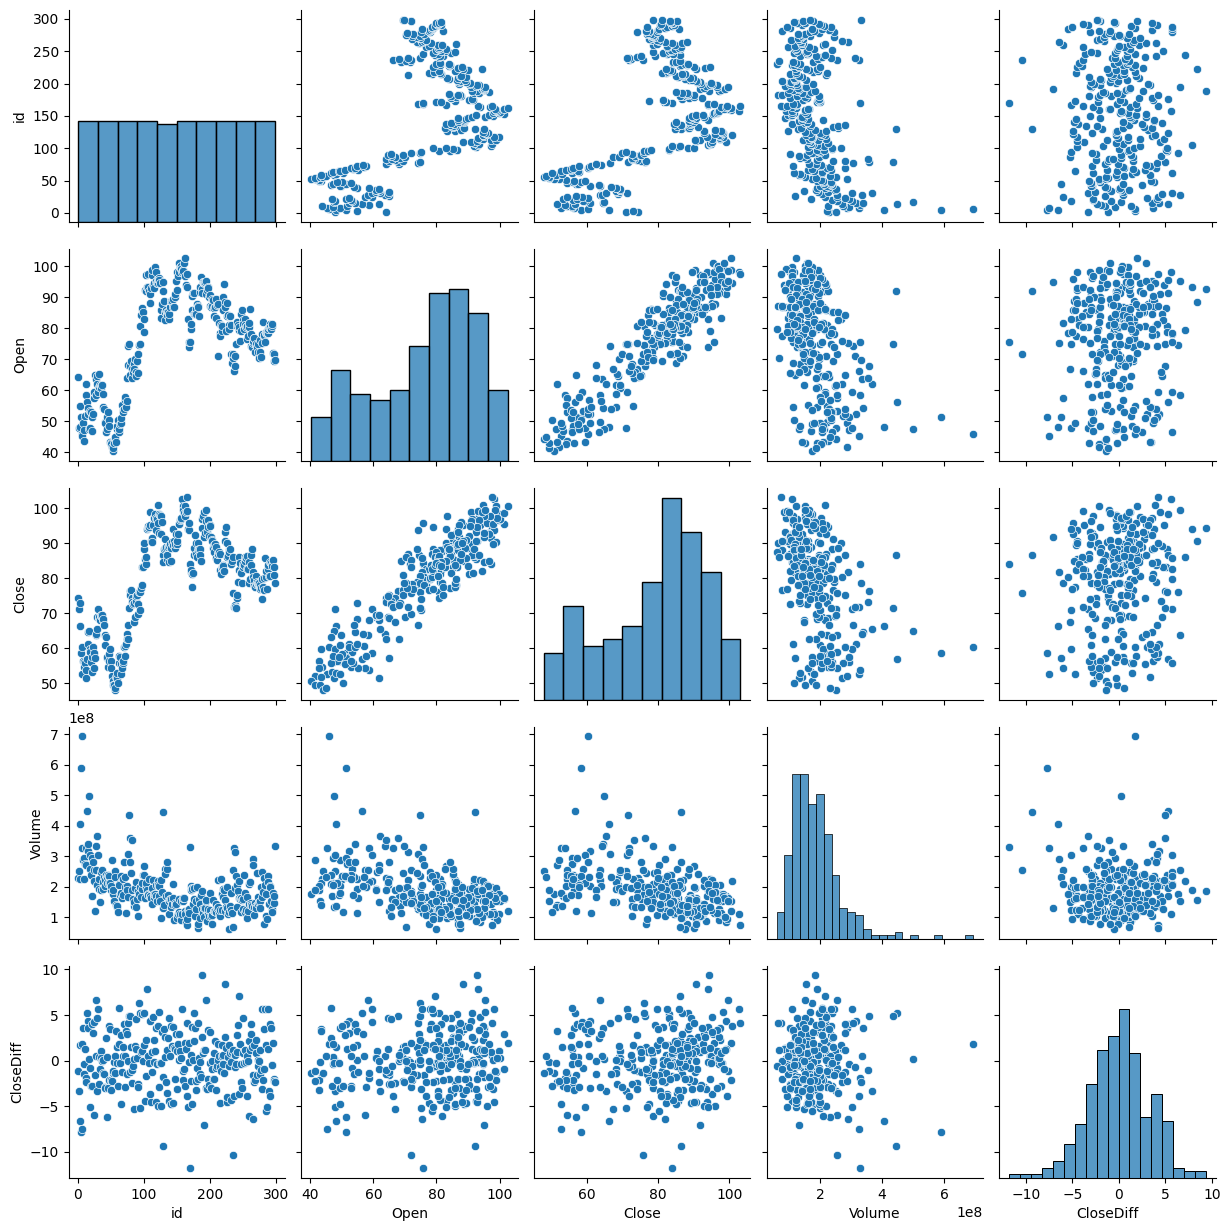

In [14]:
sns.pairplot(ts_data)

**The code generates a pair plot for the time series data, allowing for a visual exploration of pairwise relationships between variables. This plot is helpful in identifying potential correlations and patterns within the data.**
**Looks like only 'Open' and 'Close' are correlated. And other columns have no effect on 'Close'**

In [15]:
ts_data = pd.read_csv("/kaggle/input/ue21cs342aa2/train.csv")
ts_data['Date'] = pd.to_datetime(ts_data['Date'])
ts_data.set_index('Date', inplace=True)

ts_data = pd.get_dummies(ts_data, columns=['Strategy'])

In [16]:
ts_data['Moving_Average'] = ts_data['Open'].rolling(window=2).mean()
ts_data['Moving_Average'].iloc[0] = ts_data['Open'].iloc[0]

**The code calculates the moving average for the time series by taking a rolling window of size 2 on the 'Open' column.**

In [17]:
ts_data['Open_Percentage_Change'] = ts_data['Open'].pct_change()
ts_data['Short_MA'] = ts_data['Open'].rolling(window=10).mean()
ts_data['Long_MA'] = ts_data['Open'].rolling(window=50).mean()
ts_data['RSI'] = compute_rsi(ts_data['Open'])
ts_data['Volatility_BBM'] = ts_data['Open'].rolling(window=20).mean()
ts_data['Volatility_BBW'] = ts_data['Open'].rolling(window=20).std()
ts_data['Volatility_BBP'] = (ts_data['Open'] - ts_data['Volatility_BBM']) / (2 * ts_data['Volatility_BBW'])
ts_data['Momentum_RSI'] = ts_data['Open'].diff(14)
ts_data['Trend_MACD'] = compute_macd(ts_data['Open'])  

ts_data['Vol_Moving_Average'] = ts_data['Volume'].rolling(window=2).mean()
ts_data['Vol_Moving_Average'].iloc[0] = ts_data['Volume'].iloc[0]
ts_data['Volume_Percentage_Change'] = ts_data['Volume'].pct_change()
ts_data['Vol_Short_MA'] = ts_data['Volume'].rolling(window=10).mean()
ts_data['Vol_Long_MA'] = ts_data['Volume'].rolling(window=50).mean()
ts_data['Vol_RSI'] = compute_rsi(ts_data['Volume'])
ts_data['Vol_Volatility_BBM'] = ts_data['Volume'].rolling(window=20).mean()
ts_data['Vol_Volatility_BBW'] = ts_data['Volume'].rolling(window=20).std()
ts_data['Vol_Volatility_BBP'] = (ts_data['Volume'] - ts_data['Volatility_BBM']) / (2 * ts_data['Volatility_BBW'])
ts_data['Vol_Momentum_RSI'] = ts_data['Volume'].diff(14)
ts_data['Vol_Trend_MACD'] = compute_macd(ts_data['Volume'])
ts_data['Volume_OBV'] = compute_obv(ts_data['Open'], ts_data['Volume']) 

**The codes above calculate various technical indicators and statistics for both "Open" and "Volume" data, which can be used as feature engineering.**

1. `ts_data['Open_Percentage_Change'] = ts_data['Open'].pct_change()`: Calculates the percentage change in the "Open" price.

2. `ts_data['Short_MA'] = ts_data['Open'].rolling(window=10).mean()`: Computes the 10-day rolling mean (short-term moving average) of the "Open" price.

3. `ts_data['Long_MA'] = ts_data['Open'].rolling(window=50).mean()`: Computes the 50-day rolling mean (long-term moving average) of the "Open" price.

4. `ts_data['RSI'] = compute_rsi(ts_data['Open'])`: Calculates the Relative Strength Index (RSI) for the "Open" price using a 14-day window.

5. `ts_data['Volatility_BBM'] = ts_data['Open'].rolling(window=20).mean()`: Computes the Bollinger Bands Middle Band (BBM) based on a 20-day rolling mean of the "Open" price.

6. `ts_data['Volatility_BBW'] = ts_data['Open'].rolling(window=20).std()`: Calculates the Bollinger Bands Width (BBW) based on the standard deviation of the "Open" price with a 20-day window.

7. `ts_data['Volatility_BBP'] = (ts_data['Open'] - ts_data['Volatility_BBM']) / (2 * ts_data['Volatility_BBW'])`: Computes the Bollinger Bands Percentage (BBP) for the "Open" price.

8. `ts_data['Momentum_RSI'] = ts_data['Open'].diff(14)`: Calculates the momentum of the RSI for the "Open" price over a 14-day period.

9. `ts_data['Trend_MACD'] = compute_macd(ts_data['Open'])`: Computes the Moving Average Convergence Divergence (MACD) for the "Open" price.

10. `ts_data['Vol_Moving_Average'] = ts_data['Volume'].rolling(window=2).mean()`: Calculates the 2-day rolling mean of the trading volume.

11. `ts_data['Volume_Percentage_Change'] = ts_data['Volume'].pct_change()`: Computes the percentage change in trading volume.

12. `ts_data['Vol_Short_MA'] = ts_data['Volume'].rolling(window=10).mean()`: Calculates the 10-day rolling mean (short-term moving average) of trading volume.

13. `ts_data['Vol_Long_MA'] = ts_data['Volume'].rolling(window=50).mean()`: Computes the 50-day rolling mean (long-term moving average) of trading volume.

14. `ts_data['Vol_RSI'] = compute_rsi(ts_data['Volume'])`: Calculates the Relative Strength Index (RSI) for the trading volume using a 14-day window.

15. `ts_data['Vol_Volatility_BBM'] = ts_data['Volume'].rolling(window=20).mean()`: Computes the Bollinger Bands Middle Band (BBM) for trading volume based on a 20-day rolling mean.

16. `ts_data['Vol_Volatility_BBW'] = ts_data['Volume'].rolling(window=20).std()`: Calculates the Bollinger Bands Width (BBW) for trading volume based on the standard deviation with a 20-day window.

17. `ts_data['Vol_Volatility_BBP'] = (ts_data['Volume'] - ts_data['Volatility_BBM']) / (2 * ts_data['Volatility_BBW'])`: Computes the Bollinger Bands Percentage (BBP) for trading volume.

18. `ts_data['Vol_Momentum_RSI'] = ts_data['Volume'].diff(14)`: Calculates the momentum of the RSI for trading volume over a 14-day period.

19. `ts_data['Vol_Trend_MACD'] = compute_macd(ts_data['Volume'])`: Computes the Moving Average Convergence Divergence (MACD) for trading volume.

20. `ts_data['Volume_OBV'] = compute_obv(ts_data['Open'], ts_data['Volume'])`: Calculates the On-Balance Volume (OBV) for the "Open" price based on trading volume.

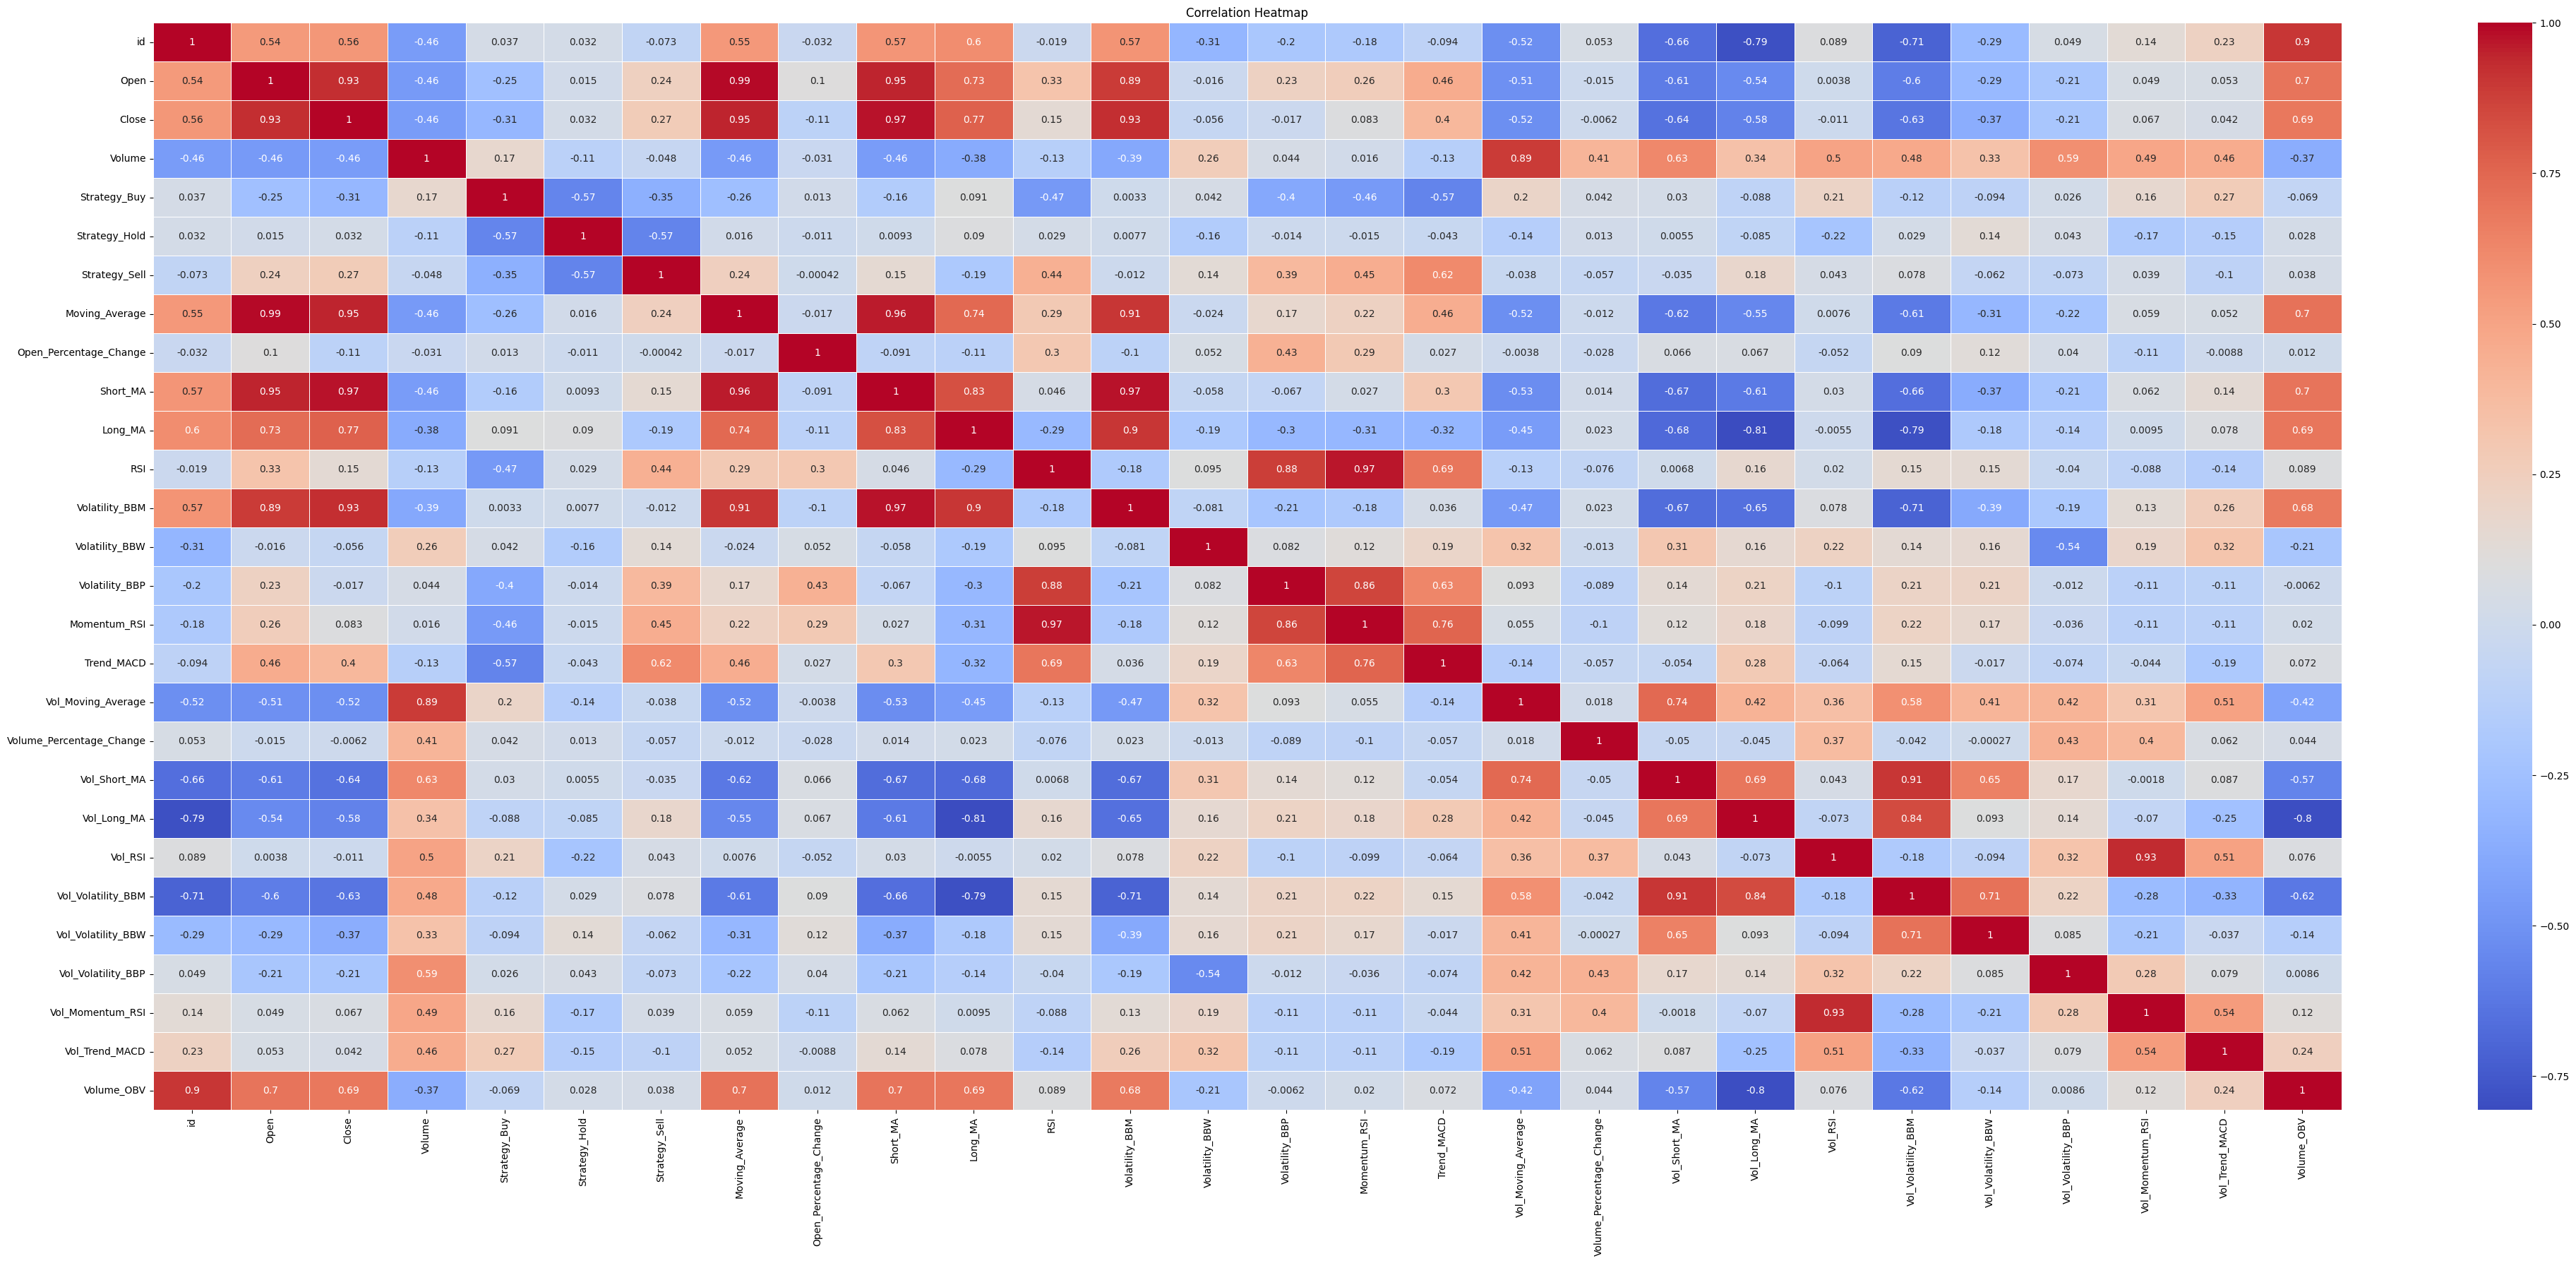

In [18]:
correlation_matrix = ts_data.corr()
plt.figure(figsize=(50, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

**The code generates a correlation heatmap for the 'Close' column and visualizes the pairwise correlations among the variables. This heatmap provides insights into the relationships between the 'Close' column and other variables in the dataset, which can be useful for feature selection and understanding data associations.**

**Although, we ended up using all the features engineered by us because otherwise the SMAPE value seemed to be higher.**

In [19]:
train_size = int(len(ts_data) * 0.8)
train = ts_data[:train_size]
validation = ts_data[train_size:]

**The code splits the time series data into training and validation sets, with 80% of the data used for training and 20% for validation.**

In [20]:
exog_train = train.drop('Close', axis = 1)
y_train = train['Close']
exog_validation = validation.drop('Close', axis = 1)
y_validation = validation['Close']

**The code separates the endogenous variable 'Close' from the exogenous variables in both the training and validation datasets, which is a common step in preparing data for modeling. This separation enables the modeling of the target variable 'Close' based on the other features in the datasets.**

In [21]:
exog_train = exog_train.dropna()
exog_validation = exog_validation.dropna()
y_train = y_train[exog_train.index]
y_validation = y_validation[exog_validation.index]

**The code removes rows with NULL values from the exogenous variables in both the training and validation datasets, ensuring that the response variable `y_train` and `y_validation` only contain corresponding non-NULL rows.**

In [22]:
scaler = StandardScaler()
exog_train = scaler.fit_transform(exog_train)
exog_validation = scaler.transform(exog_validation)

**The code applies StandardScaler to scale the exogenous variables in the training and validation datasets, ensuring that all values are in the same range. This scaling is essential for many machine learning algorithms as it helps prevent features with larger scales from dominating the modeling process, promoting fairer comparisons between variables.**

**We tried with RobustScaler and MinMAxScaler, but no use :/**

In [23]:
ts_model = sm.tsa.SARIMAX(y_train,
                          exog=exog_train,
                          order=(1, 1, 2),
                          seasonal_order=(0, 0, 0, 0),
                          enforce_stationarity=True,
                          enforce_invertibility=True)
ts_results = ts_model.fit()

print(ts_results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.09088D+00    |proj g|=  3.39783D-02

At iterate    5    f=  2.06624D+00    |proj g|=  1.46256D-02


 This problem is unconstrained.



At iterate   10    f=  2.05580D+00    |proj g|=  7.56426D-03

At iterate   15    f=  2.05091D+00    |proj g|=  2.90972D-03

At iterate   20    f=  2.04822D+00    |proj g|=  3.86461D-03

At iterate   25    f=  2.04432D+00    |proj g|=  8.80147D-03

At iterate   30    f=  2.04305D+00    |proj g|=  1.22931D-02

At iterate   35    f=  2.04148D+00    |proj g|=  4.82844D-03

At iterate   40    f=  2.04036D+00    |proj g|=  3.82558D-03

At iterate   45    f=  2.03949D+00    |proj g|=  1.77722D-03

At iterate   50    f=  2.03883D+00    |proj g|=  4.67060D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31     50     53   

**The code defines and fits a SARIMAX time series forecasting model using the provided training data and exogenous variables. The model has a seasonal order of (0, 0, 0, 0) and uses an order of (1, 1, 2) for the autoregressive, differencing, and moving average components. The enforce_stationarity and enforce_invertibility parameters are set to ensure stationarity and invertibility of the model.**

**Even though we got a value of 1, 1, 1 from the ACF and PACF plots, we chose 1, 1, 2 through hyperparameter tuning because it performed better with the SMAPE value!**

In [24]:
close_price_predictions = ts_results.predict(start=len(y_train), end=len(y_train) + len(exog_validation) - 1, exog=exog_validation)
print("Predicted Close Prices:")
close_price_predictions

Predicted Close Prices:


2020-01-06    72.118112
2020-01-13    71.548387
2020-01-20    75.158851
2020-01-27    76.017590
2020-02-03    77.488134
2020-02-10    79.572014
2020-02-17    79.489835
2020-02-24    79.955338
2020-03-02    78.337582
2020-03-09    79.190217
2020-03-16    81.958472
2020-03-23    83.046471
2020-03-30    82.793773
2020-04-06    83.786554
2020-04-13    86.818319
2020-04-20    87.283057
2020-04-27    86.645161
2020-05-04    83.268194
2020-05-11    83.999867
2020-05-18    82.566195
2020-05-25    79.644431
2020-06-01    78.281690
2020-06-08    83.418127
2020-06-15    88.299664
2020-06-22    86.797670
2020-06-29    81.721106
2020-07-06    81.799809
2020-07-13    77.304197
2020-07-20    79.187300
2020-07-27    76.639740
2020-08-03    76.280788
2020-08-10    78.440046
2020-08-17    74.560826
2020-08-24    74.754743
2020-08-31    73.931518
2020-09-07    74.166536
2020-09-14    73.638716
2020-09-21    72.507144
2020-09-28    73.166616
2020-10-05    73.842234
2020-10-12    75.707215
2020-10-19    71

**The code uses the time series model results to forecast the open prices for the validation set. It predicts the close prices based on the exogenous variables provided in `exog_validation` and prints the forecasted close prices, enabling evaluation and analysis of the model's performance.**

# SMAPE CALCULATIONS

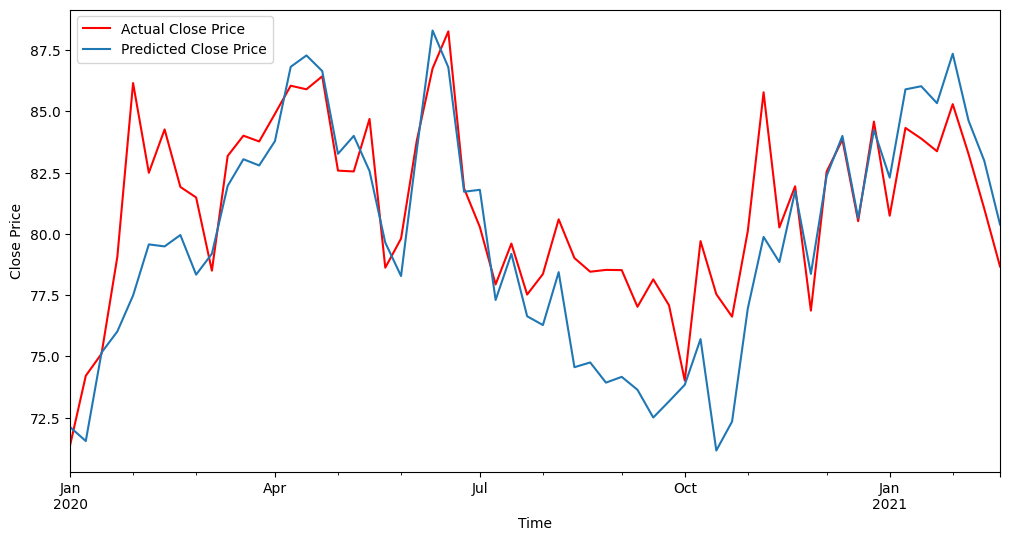

In [25]:
y_validation.plot(figsize=(12, 6), color='red', label='Actual Close Price')
close_price_predictions.plot(label='Predicted Close Price')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

**The code generates a line plot comparing the actual close price (`y_validation`) in red with the predicted close price (`close_price_predictions`). This visualization helps to assess the model's forecasting performance.**
**Inferences:**
**1. Red line: Represents the actual close prices from the validation data.**
**2. Blue line: Represents the predicted close prices generated by the SARIMAX model.**
**This plot visually shows how well the model's predictions align with the actual close prices, allowing for an assessment of forecasting accuracy.**

In [26]:
smape = 100 * np.mean(np.abs(close_price_predictions - y_validation) / (np.abs(close_price_predictions) + np.abs(y_validation)))
print(f"SMAPE for SARIMAX = {smape:.5f}%")

SMAPE for SARIMAX = 1.32062%


**The code calculates the Symmetric Mean Absolute Percentage Error (SMAPE) for the SARIMAX(ARIMAX) model, providing a percentage-based measure of forecast accuracy. The resulting SMAPE value quantifies the model's predictive performance, making it a useful metric for evaluating the accuracy of time series forecasts.**

# STRATEGY

In [27]:
data = pd.read_csv('/kaggle/input/ue21cs342aa2/train.csv')

In [28]:
label_encoder = LabelEncoder()
data['Strategy'] = label_encoder.fit_transform(data['Strategy'])

**The code uses a Label Encoder to encode the "Strategy" column into three categories: Buy, Sell, and Hold. This encoding is commonly used in machine learning to represent categorical data numerically, making it suitable for model training and analysis.**

In [29]:
data['Open_Percentage_Change'] = data['Open'].pct_change() * 100
data['Close_Percentage_Change'] = data['Close'].pct_change() * 100

**Open_Percentage_Change: This feature calculates the percentage change in the "Open" prices. It quantifies how much the "Open" price has changed concerning the previous data point, and expresses it as a percentage.**

**Close_Percentage_Change: This feature computes the percentage change in the "Close" prices. It measures the relative change in the "Close" price compared to the preceding data point and represents it as a percentage.**

In [30]:
lag_periods = 1
data['Open_Lagged'] = data['Open'].shift(lag_periods)  
data['Close_Lagged'] = data['Close'].shift(lag_periods)  
data['Volume_Lagged'] = data['Volume'].shift(lag_periods)  
data['Volume_Percentage_Change'] = data['Volume'].pct_change() * 100
data['RSI'] = calculate_rsi(data)

data['volatility_bbm'] = calculate_volatility_bbm(data)
data['volatility_bbw'] = calculate_volatility_bbw(data)
data['volatility_bbp'] = calculate_volatility_bbp(data)
data['momentum_rsi'] = calculate_momentum_rsi(data)
data['trend_macd'] = calculate_trend_macd(data)
data['volume_obv'] = calculate_volume_obv(data)

**The code creates lagged features for the 'Open,' 'Close,' and 'Volume' columns with a lag period of 1, allowing the model to capture past values. It also computes the percentage change in 'Volume,' calculates the Relative Strength Index (RSI), and derives additional technical indicators related to volatility, momentum, and trend, enhancing the feature set for analysis or modeling.**

1. `n_estimators=100`: The number of boosting rounds (trees) in the XGBoost model.

2. `learning_rate=0.1`: The step size shrinkage to prevent overfitting.

3. `max_depth=10`: The maximum depth of the individual decision trees in the ensemble.

4. `min_child_weight=1`: The minimum sum of instance weight (hessian) needed in a child.

5. `subsample=1.0`: The fraction of samples used for fitting the trees.

6. `colsample_bytree=1.0`: The fraction of features used for fitting each tree.

7. `gamma=0`: Minimum loss reduction required to make a further partition on a leaf node.

8. `reg_lambda=1`: L2 regularization term on weights.

9. `reg_alpha=0`: L1 regularization term on weights.

10. `scale_pos_weight=1`: Controls the balance of positive and negative weights.

11. `objective='multi:softmax'`: The learning task and objective, which is multi-class classification using softmax.

12. `eval_metric='logloss'`: The evaluation metric used to monitor model performance during training, which is log loss in this case.

In [31]:
short_window = 10  
long_window = 50 

data['Short_MA'] = data['Close'].rolling(window=short_window).mean()
data['Long_MA'] = data['Close'].rolling(window=long_window).mean()

**These moving average features are commonly used in financial analysis to identify trends and patterns in time series data. The short-term moving average responds quickly to recent price changes, while the long-term moving average provides a smoother trend representation by considering a more extended historical period.**

In [32]:
X = data[['Short_MA', 'Long_MA', 'RSI', 'Open_Lagged', 'Close_Lagged', 'Volume_Lagged','volatility_bbm', 'volatility_bbw', 'volatility_bbp', 'trend_macd', 'volume_obv']]
y = data['Strategy']

**The code defines the feature variables (X) consisting of various technical indicators and lagged values. The target variable (y) is 'Strategy,' likely for a classification task, where the model aims to predict trading strategies based on the provided features.**

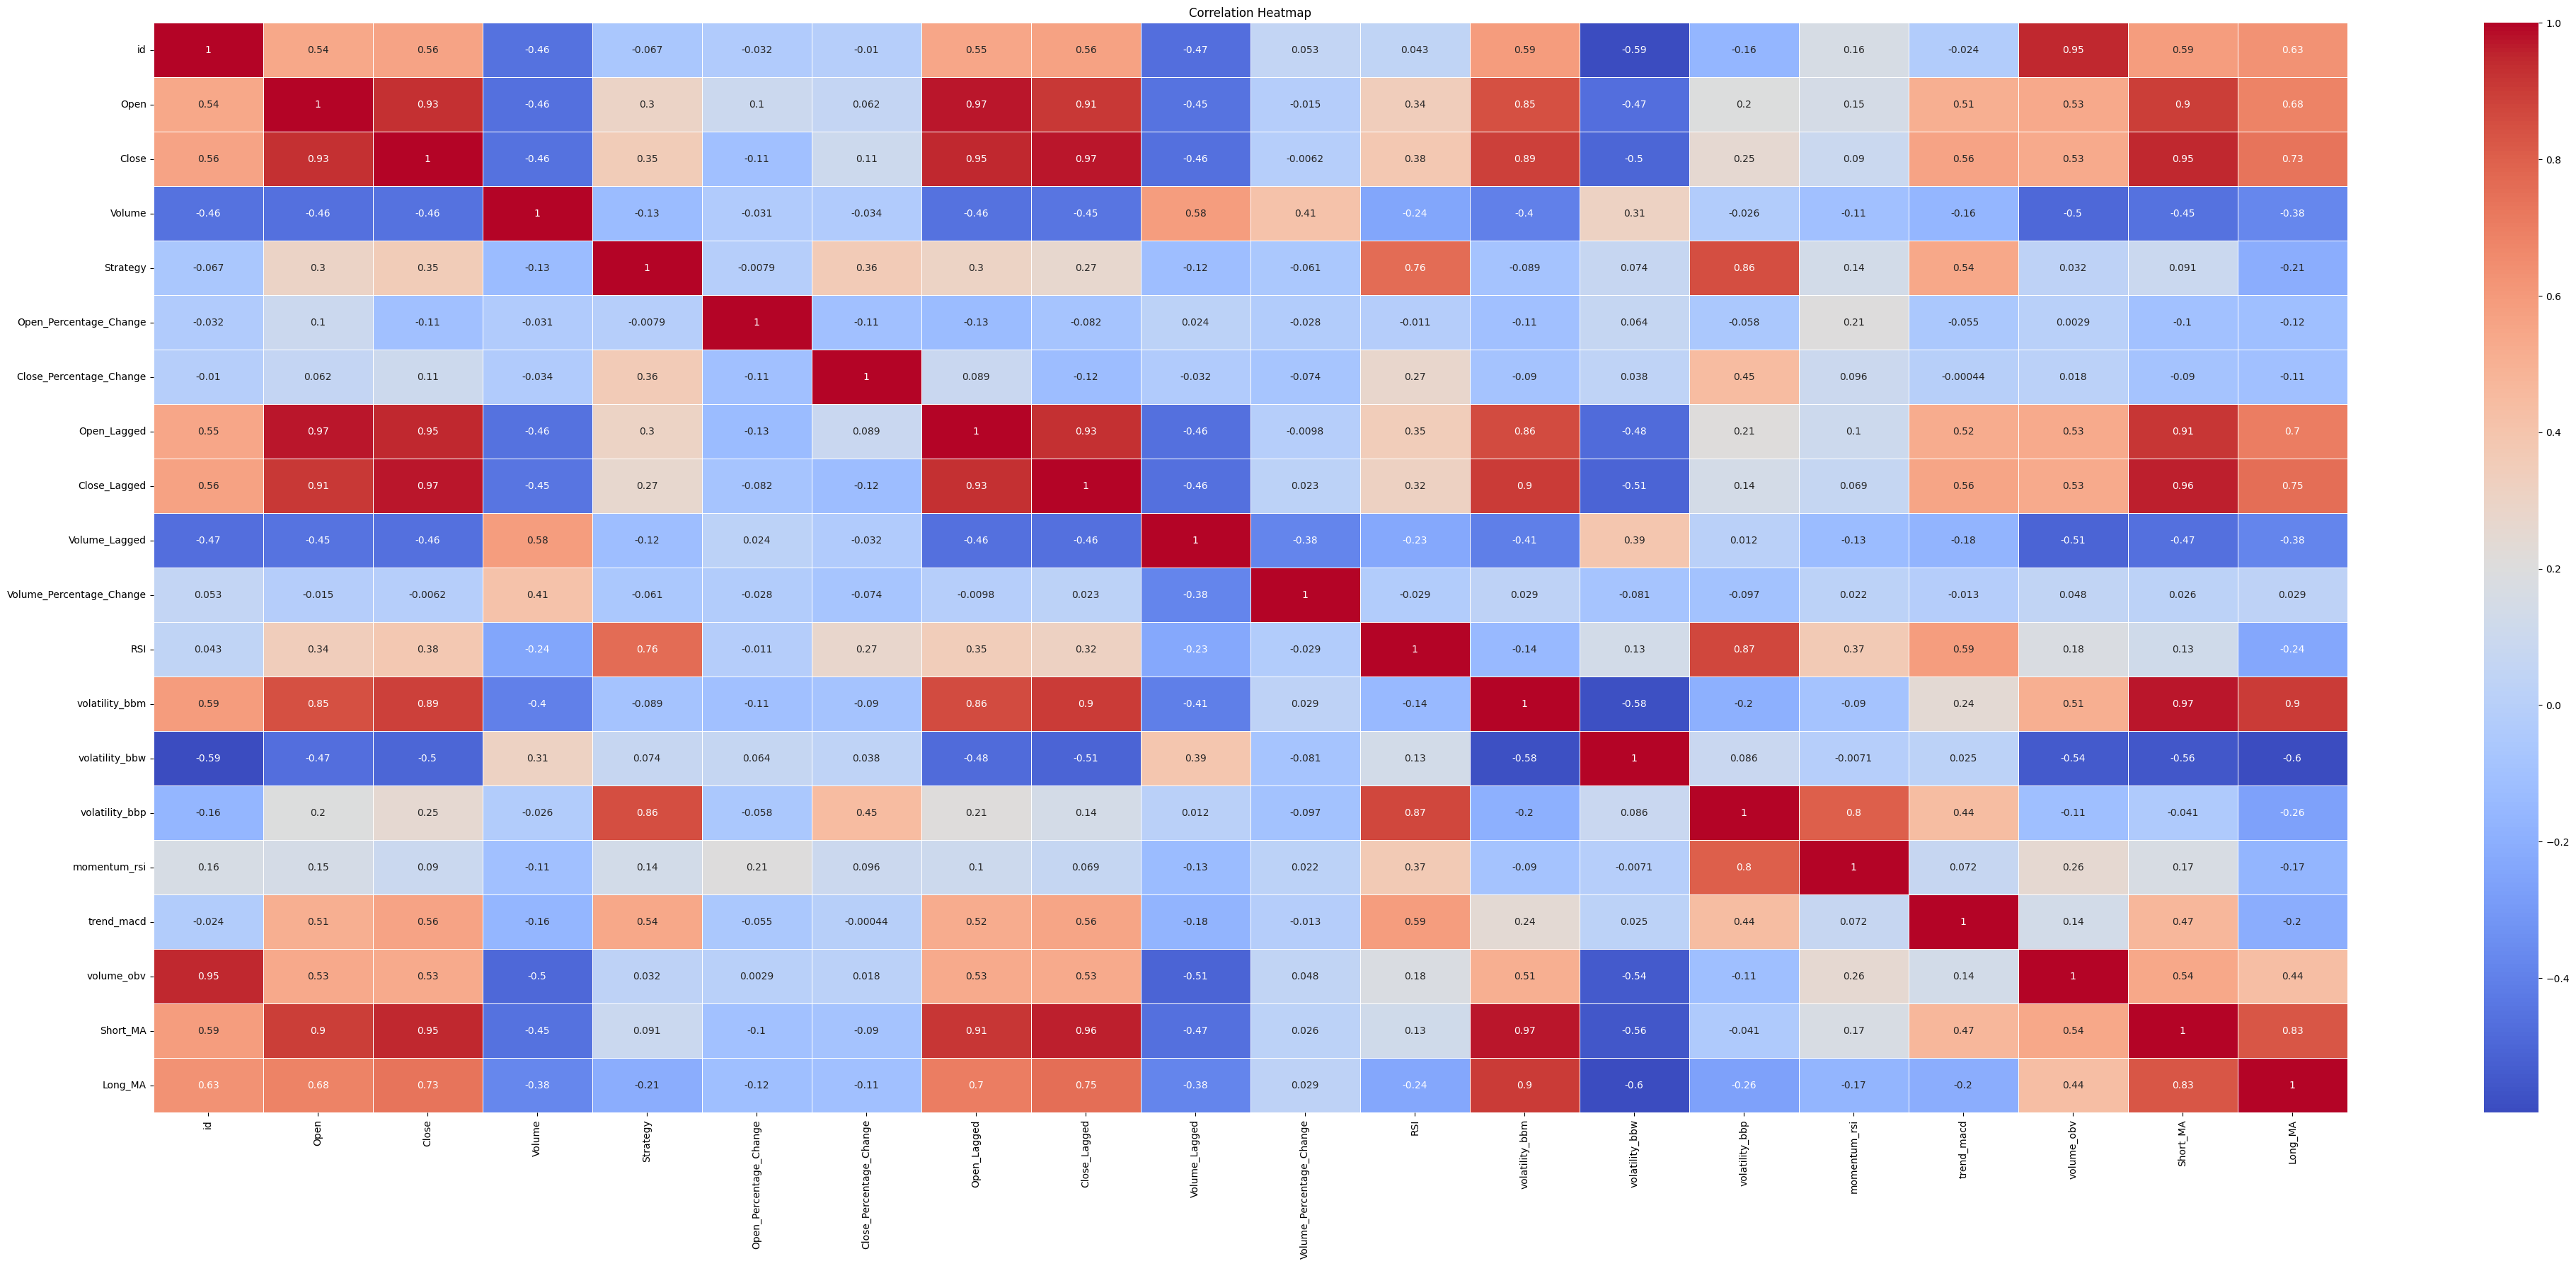

In [33]:
numeric_data = data.select_dtypes(include=[np.number])

correlation_matrix = numeric_data.corr()
plt.figure(figsize=(50, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

**We ended up using all the features engineered by us because otherwise the accuracy seemed to be lower.**

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

**The code splits the data into training and testing sets, with 80% for training and 20% for testing. This random splitting is crucial for assessing the model's performance on unseen data and mitigating overfitting concerns.**

In [35]:
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=10,
    min_child_weight=1,
    subsample=1.0,
    colsample_bytree=1.0,
    gamma=0,
    reg_lambda=1,
    reg_alpha=0,
    scale_pos_weight=1,
    objective='multi:softmax',
    eval_metric='logloss',
)

**The code creates an XGBoost classifier for a multiclass classification task with specific hyperparameters.
This XGBoost classifier is configured for training and evaluation on the specified classification problem.**

In [36]:
xgb_model.fit(X_train, y_train)

[07:47:34] WARNING: ../src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None, ...)

**The code fits an XGBoost model to the training data, enabling the model to learn patterns and relationships between the features (X) and the target variable (y). This step is fundamental in supervised machine learning for model training.**

In [37]:
y_pred = xgb_model.predict(X_test)

**y_pred = xgb_model.predict(X_test)
This code makes predictions for the "Strategy" variable on the test data using the previously trained XGBoost classifier. The predictions are stored in the variable "y_pred."**

# ACCURACY CALCULATIONS

In [38]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy for XGBoost model:", accuracy)

Accuracy for XGBoost model: 0.9


In [39]:
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

         Buy       0.90      0.83      0.86        23
        Hold       0.86      0.93      0.89        40
        Sell       0.96      0.93      0.94        27

    accuracy                           0.90        90
   macro avg       0.91      0.89      0.90        90
weighted avg       0.90      0.90      0.90        90



# TEST DATA PREDICTIONS

In [40]:
test_data = pd.read_csv("/kaggle/input/ue21cs342aa2/test.csv")
test_data['Date'] = pd.to_datetime(test_data['Date'])
test_data.set_index('Date', inplace=True)

In [41]:
test_data['Open_Percentage_Change'] = test_data['Open'].pct_change()
test_data['Short_MA'] = test_data['Open'].rolling(window=10).mean()
test_data['Long_MA'] = test_data['Open'].rolling(window=50).mean()
test_data['RSI'] = compute_rsi(test_data['Open'])  
test_data['Volatility_BBM'] = test_data['Open'].rolling(window=20).mean()
test_data['Volatility_BBW'] = test_data['Open'].rolling(window=20).std()
test_data['Volatility_BBP'] = (test_data['Open'] - test_data['Volatility_BBM']) / (2 * test_data['Volatility_BBW'])
test_data['Momentum_RSI'] = test_data['Open'].diff(14)  
test_data['Trend_MACD'] = compute_macd(test_data['Open'])  

test_data['Volume_Percentage_Change'] = test_data['Volume'].pct_change()
test_data['Vol_Short_MA'] = test_data['Volume'].rolling(window=10).mean()
test_data['Vol_Long_MA'] = test_data['Volume'].rolling(window=50).mean()
test_data['Vol_RSI'] = compute_rsi(test_data['Volume'])
test_data['Vol_Volatility_BBM'] = test_data['Volume'].rolling(window=20).mean()
test_data['Vol_Volatility_BBW'] = test_data['Volume'].rolling(window=20).std()
test_data['Vol_Volatility_BBP'] = (test_data['Volume'] - test_data['Volatility_BBM']) / (2 * test_data['Volatility_BBW'])
test_data['Vol_Momentum_RSI'] = test_data['Volume'].diff(14)
test_data['Vol_Trend_MACD'] = compute_macd(test_data['Volume'])

test_data['Volume_OBV'] = compute_obv(test_data['Open'], test_data['Volume'])

test_data['Moving_Average'] = test_data['Open'].rolling(window=2).mean()
test_data['Moving_Average'].iloc[0] = test_data['Open'].iloc[0]
test_data['Open_Lagged'] = test_data['Open'].shift(3)

test_data['Vol_Moving_Average'] = test_data['Volume'].rolling(window=2).mean()
test_data['Vol_Moving_Average'].iloc[0] = test_data['Volume'].iloc[0]

for column in test_data.columns:
    if column != 'Date' and column != 'id':
        test_data[column].fillna(test_data[column].mean(), inplace=True)

exog_test = test_data[['Open', 'Moving_Average', 'Open_Percentage_Change', 'Short_MA', 'Long_MA', 'RSI', 'Volatility_BBM', 'Volatility_BBW', 'Volatility_BBP', 'Momentum_RSI', 'Trend_MACD', 'Vol_Moving_Average', 'Volume_Percentage_Change', 'Vol_Short_MA', 'Vol_Long_MA', 'Vol_RSI', 'Vol_Volatility_BBM', 'Vol_Volatility_BBW', 'Vol_Volatility_BBP', 'Vol_Momentum_RSI', 'Vol_Trend_MACD', 'Volume_OBV', 'Open_Lagged']]

In [42]:
test_pred = ts_results.predict(start=0, end=len(test_data) - 1, exog=exog_test)
test_data['Close'] = test_pred.values

In [43]:
test_data['Close_Percentage_Change'] = test_data['Close'].pct_change() * 100
test_data['Open_Lagged'] = test_data['Open'].shift(lag_periods)  
test_data['Close_Lagged'] = test_data['Close'].shift(lag_periods)  
test_data['Volume_Lagged'] = test_data['Volume'].shift(lag_periods)  
test_data['volatility_bbm'] = calculate_volatility_bbm(test_data)
test_data['volatility_bbw'] = calculate_volatility_bbw(test_data)
test_data['volatility_bbp'] = calculate_volatility_bbp(test_data)
test_data['momentum_rsi'] = calculate_momentum_rsi(test_data)
test_data['trend_macd'] = calculate_trend_macd(test_data)
test_data['volume_obv'] = calculate_volume_obv(test_data)

In [44]:
test_classification = xgb_model.predict(test_data[['Short_MA', 'Long_MA', 'RSI', 'Open_Lagged', 'Close_Lagged', 'Volume_Lagged', 'volatility_bbm', 'volatility_bbw', 'volatility_bbp', 'trend_macd', 'volume_obv']])

In [45]:
test_data['Strategy'] = test_classification

In [46]:
test_data['Strategy'] = label_encoder.inverse_transform(test_data['Strategy'])

**This is for the "Strategy" column to have the values 'Buy', 'Hold', 'Sell' and not the encoded format.**

In [47]:
test_data_with_predictions = test_data[['id', 'Close', 'Strategy']]

**Choosing the columns that are only required for the final submission.**

In [48]:
test_data_with_predictions.to_csv("submission.csv", index=True)

**submission.csv created :)**